<a href="https://colab.research.google.com/github/beyzaturku/Weather_Detection_Using_CNN/blob/main/Weather_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!python --version

Python 3.11.11


In [2]:
!pip install opencv-python

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
zip_path = '/content/drive/MyDrive/Weather_Detection/wd_dataset.zip'

In [14]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adamax
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay
import warnings
warnings.filterwarnings("ignore")

Google Colab'a dosya yükleme işlemi

In [15]:
from google.colab import files
uploaded = files.upload()

Saving wd_dataset.zip to wd_dataset.zip


In [39]:
import os
import cv2
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, GlobalAveragePooling2D, BatchNormalization
from tensorflow.keras.optimizers import Adamax

Veri Setini Yükleme

In [40]:
image_folder = "Multi-class Weather Dataset"

In [42]:
subfolders = [ 'Cloudy', 'Rain', 'Shine', 'Sunrise']
label_map = { subfolder: idx for idx, subfolder in enumerate(subfolders)}

# List of Images and Labels
images = []
labels = []

# Loading Dataset

for subfolder in subfolders:
    subfolder_path = os.path.join(image_folder, subfolder)
    for filename in os.listdir(subfolder_path):
        img_path = os.path.join(subfolder_path, filename)
        img = cv2.imread(img_path)
        if img is not None:
            img_resized = cv2.resize(img, (224,224))
            images.append(img_resized)
            labels.append(label_map[subfolder])

# Coverted to Numpy Arrays
images = np.array(images)
labels = np.array(labels)

# Normalize the Images
images = images.astype('float32') / 255.0

Bazı Rastgele Örnekler

In [43]:
# Plot 5 images from each class
plt.figure(figsize = (15,15))
for i, subfolder in enumerate(subfolders):
    class_indices = np.where(labels == label_map[subfolder])[0]
    for j in range(5):
        plt.subplot(len(subfolders), 5, i*5 + j +1)
        plt.imshow(images[class_indices[j]])
        plt.title(f"Class {subfolder}")
        plt.axis('off')
plt.suptitle('Sample Images from Each Class')
plt.show()

Veri Görselleştirme

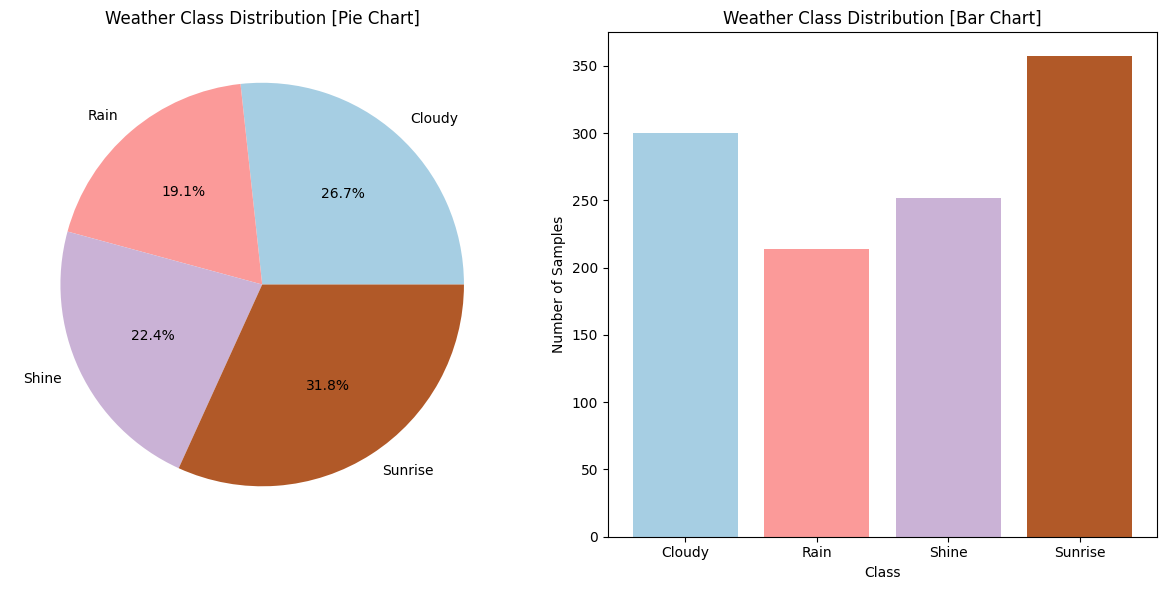

In [44]:
# Visual Representation for Class Distribution [ Pie Chart, Bar Chart]

class_counts = np.bincount(labels)
plt.figure(figsize = (12,6))

plt.subplot(1,2,1)
colors = plt.cm.Paired(np.linspace(0, 1, len(class_counts)))
plt.pie(class_counts, labels = subfolders, autopct = '%1.1f%%', colors = colors)
plt.title( 'Weather Class Distribution [Pie Chart]')

plt.subplot(1,2,2)
colors = plt.cm.Paired(np.linspace(0, 1, len(class_counts)))
plt.bar(subfolders, class_counts, color = colors)
plt.title('Weather Class Distribution [Bar Chart]')
plt.xlabel('Class')
plt.ylabel('Number of Samples')

plt.tight_layout()
plt.show()

In [45]:
# One-Hot Encode the labels

labels_one_hot = tf.keras.utils.to_categorical(labels, num_classes = len(subfolders))

Veri Setini Bölme

In [46]:
X_train, X_test, y_train, y_test = train_test_split(images, labels_one_hot, test_size = 0.2, stratify = labels_one_hot, random_state = 42)

In [47]:
print("Training data shape:", X_train.shape, "Training labels shape:", y_train.shape)
print("Test data shape:", X_test.shape, "Test labels shape:", y_test.shape)

Training data shape: (898, 224, 224, 3) Training labels shape: (898, 4)
Test data shape: (225, 224, 224, 3) Test labels shape: (225, 4)


Model Mimarisi - Basit CNN

In [48]:
model = Sequential([
    Conv2D(64, (3,3), activation ='relu', input_shape = (224,224,3)),
    MaxPooling2D((2,2)),
    Dropout(0.25),
    Conv2D(64, (3,3), activation ='relu'),
    MaxPooling2D((2,2)),
    Dropout(0.25),
    Conv2D(128, (3,3), activation ='relu'),
    MaxPooling2D((2,2)),
    Dropout(0.25),
    Flatten(),
    Dense(128, activation = 'relu'),
    Dropout(0.1),
    Dense(len(subfolders), activation = 'softmax')

])

model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)                    │ (None, 222, 222, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_6 (MaxPooling2D)       │ (None, 111, 111, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 111, 111, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 109, 109, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_7 (MaxPooling2D)       │ (None, 54, 54, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 54, 54, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_8 (Conv2D)                    │ (None, 52, 52, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_8 (MaxPooling2D)       │ (None, 26, 26, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 26, 26, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ (None, 86528)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 128)                 │      11,075,712 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_7 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 4)                   │             516 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 11,188,804 (42.68 MB)

 Trainable params: 11,188,804 (42.68 MB)

 Non-trainable params: 0 (0.00 B)

Model Eğitimi

In [49]:
model.compile(optimizer = 'adam',
             loss = 'categorical_crossentropy',
             metrics = ['accuracy'])

In [50]:
history = model.fit(X_train, y_train, epochs = 12, validation_data = (X_test, y_test))

Epoch 1/12
29/29 ━━━━━━━━━━━━━━━━━━━━ 19s 372ms/step - accuracy: 0.3570 - loss: 4.3945 - val_accuracy: 0.4889 - val_loss: 0.9078
Epoch 2/12
29/29 ━━━━━━━━━━━━━━━━━━━━ 2s 79ms/step - accuracy: 0.6676 - loss: 0.8511 - val_accuracy: 0.6933 - val_loss: 0.5905
Epoch 3/12
29/29 ━━━━━━━━━━━━━━━━━━━━ 2s 75ms/step - accuracy: 0.7206 - loss: 0.7567 - val_accuracy: 0.8311 - val_loss: 0.5393
Epoch 4/12
29/29 ━━━━━━━━━━━━━━━━━━━━ 2s 82ms/step - accuracy: 0.7935 - loss: 0.5239 - val_accuracy: 0.7689 - val_loss: 0.5317
Epoch 5/12
29/29 ━━━━━━━━━━━━━━━━━━━━ 2s 79ms/step - accuracy: 0.7725 - loss: 0.6060 - val_accuracy: 0.7556 - val_loss: 0.5598
Epoch 6/12
29/29 ━━━━━━━━━━━━━━━━━━━━ 2s 76ms/step - accuracy: 0.8164 - loss: 0.4288 - val_accuracy: 0.8933 - val_loss: 0.3427
Epoch 7/12
29/29 ━━━━━━━━━━━━━━━━━━━━ 2s 75ms/step - accuracy: 0.8794 - loss: 0.3149 - val_accuracy: 0.8889 - val_loss: 0.3458
Epoch 8/12
29/29 ━━━━━━━━━━━━━━━━━━━━ 3s 79ms/step - accuracy: 0.8814 - loss: 0.2939 - val_accuracy: 0.8978 -

Model Değerlendirmesi

In [51]:
# Evaluate the model on the test set
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f'Test accuracy: {test_acc}')
print(f'Test loss: {test_loss}')

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.8989 - loss: 0.2730
Test accuracy: 0.897777795791626
Test loss: 0.27358102798461914


In [52]:
# Classification Report

y_pred = np.argmax(model.predict(X_test), axis=1)
y_true = np.argmax(y_test, axis=1)
print(classification_report(y_true, y_pred, target_names=subfolders))

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step
              precision    recall  f1-score   support

      Cloudy       0.90      0.87      0.88        60
        Rain       0.97      0.88      0.93        43
       Shine       0.78      0.84      0.81        50
     Sunrise       0.95      0.97      0.96        72

    accuracy                           0.90       225
   macro avg       0.90      0.89      0.89       225
weighted avg       0.90      0.90      0.90       225



Karışıklık Matrisi

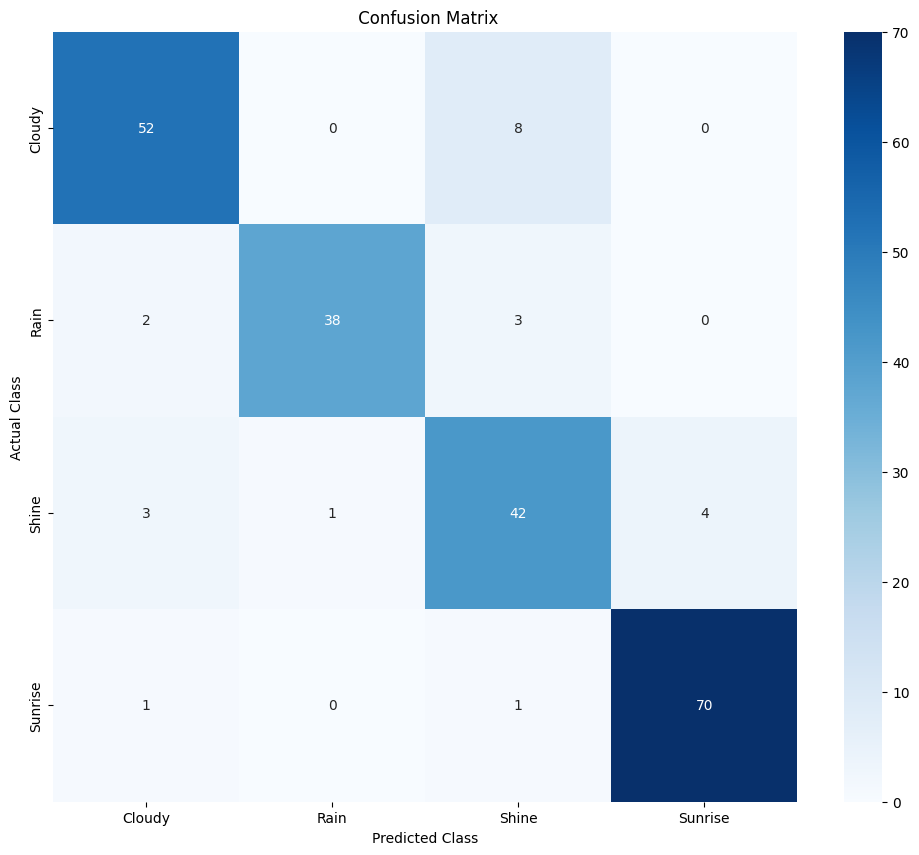

In [53]:
# Confusion Matrix
conf_mat = confusion_matrix(y_true, y_pred)
plt.figure(figsize = (12,10))
sns.heatmap(conf_mat , annot =True, fmt = 'd', cmap = 'Blues', xticklabels = subfolders, yticklabels = subfolders)
plt.title(" Confusion Matrix")
plt.xlabel("Predicted Class")
plt.ylabel("Actual Class")
plt.show()

In [54]:
# Plotting for Training and Validation Results

plt.figure(figsize = (12,6))
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label = 'Training Accuracy')
plt.plot(history.history['val_accuracy'], label = 'Validation Accuracy')
plt.title('Train VS Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['loss'], label = 'Training Loss')
plt.plot(history.history['val_loss'], label = 'Validation Loss')
plt.title('Train VS Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

Bazı Rastgele Tahmin Çalışmaları

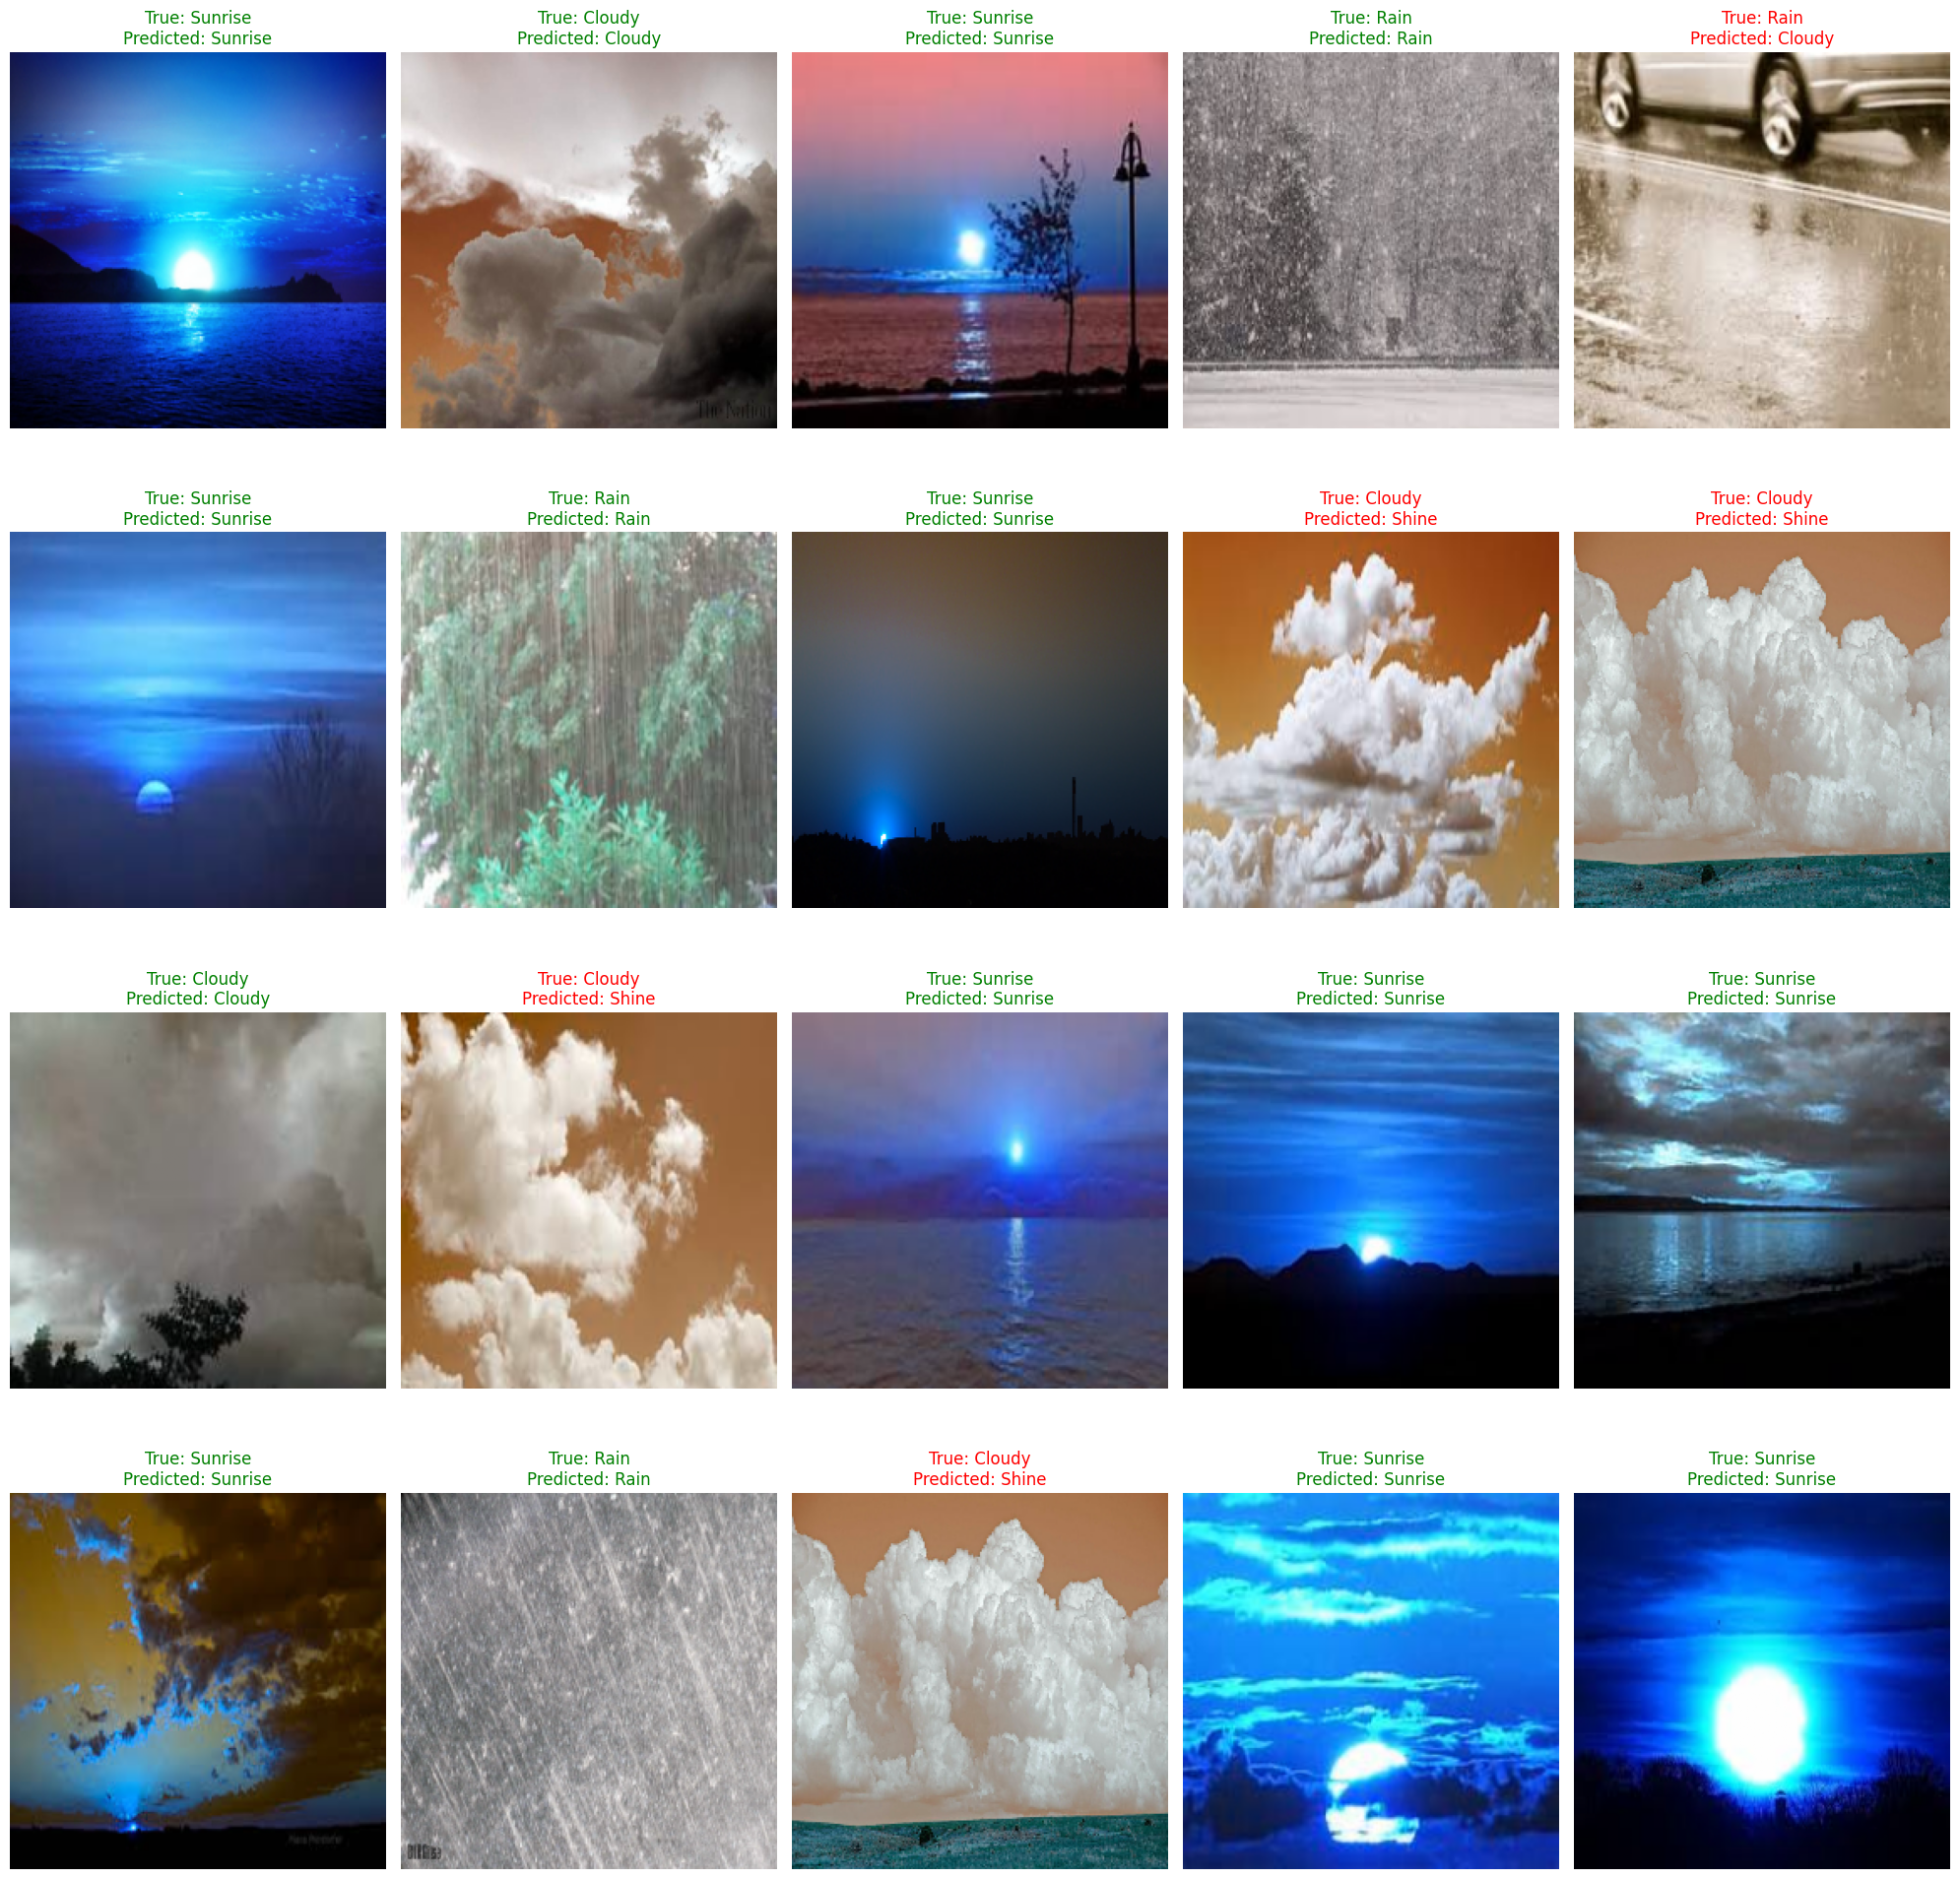

In [55]:
import random

num_samples = 20
rows = 4
wrong_predictions_indices =[]
for idx, (true_label, predicted_label) in enumerate(zip(y_true, y_pred)):
    if true_label != predicted_label:
        wrong_predictions_indices.append(idx)

random_indices = random.sample(range(len(X_test)), num_samples - rows)
random_wrong_indices = random.sample(wrong_predictions_indices, 4)
random_indices.extend(random_wrong_indices)
random_indices = sorted(random_indices)

plt.figure(figsize=(20, 20))
for i, idx in enumerate(random_indices):
    plt.subplot(rows, int(num_samples / rows), i + 1)
    plt.imshow(X_test[idx])
    true_label = y_true[idx]
    true_class = subfolders[true_label]
    predicted_class = subfolders[y_pred[idx]]

    # color-code the correct predictions
    if true_class == predicted_class:
        predicted_color = 'green'
    else:
        predicted_color = 'red'
    plt.title(f'True: {true_class}\nPredicted: {predicted_class}', color=predicted_color)
    plt.axis('off')

plt.tight_layout()
plt.show()